In [1]:
import sys
sys.path.insert(1, '/Users/mac/Desktop/PycharmProjects/TAADL/src')
sys.path.insert(2, '/Users/mac/Desktop/PycharmProjects/TAADL/models')

In [2]:
from utils import train_test_split, train_test_split2, generate_portfolio_inputs
from config import DATA_PATH, PARAM_PATH
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from optuna import trial
from strategy import RiskParity

# Data Preprocessing

In [3]:
# import data and trained network parameters
features = pd.read_csv(DATA_PATH+'/features.csv', index_col='Date')
prices   = pd.read_csv(DATA_PATH+'/prices.csv', index_col='Date')
prices.index = pd.to_datetime(prices.index)
features.index = pd.to_datetime(features.index)

X, y = train_test_split2(features, test=False)

In [4]:
data1 = generate_portfolio_inputs(X,y, num_trials=30) 
data2 = generate_portfolio_inputs(X,y, num_trials=60) 
data3 = generate_portfolio_inputs(X,y, num_trials=120) 
data4 = generate_portfolio_inputs(X,y, num_trials=250) 
data5 = generate_portfolio_inputs(X,y, num_trials=500) 

In [6]:
prices = prices.loc[data1.index]

In [7]:
df = pd.DataFrame()

print('normal Risk Parity')
rp = RiskParity(prices, data1)
rp.run(enhanced=False)
rp.performance()
df['RP_normal'] = rp.equity_curve
alloc_normal = rp.allocation

print('Risk Parity Enhanced, run1')
rp1 = RiskParity(prices, data1)
rp1.run(enhanced=True)
rp1.performance()
df['RP_enhanced_run1'] = rp1.equity_curve
alloc_run1 = rp1.allocation

print('Risk Parity Enhanced, run2')
rp2 = RiskParity(prices, data2)
rp2.run(enhanced=True)
rp2.performance()
df['RP_enhanced_run2'] = rp2.equity_curve
alloc_run2 = rp2.allocation

print('Risk Parity Enhanced, run3')
rp3 = RiskParity(prices, data3)
rp3.run(enhanced=True)
rp3.performance()
df['RP_enhanced_run3'] = rp3.equity_curve
alloc_run3 = rp3.allocation

print('Risk Parity Enhanced, run4')
rp4 = RiskParity(prices, data4)
rp4.run(enhanced=True)
rp4.performance()
df['RP_enhanced_run4'] = rp4.equity_curve
alloc_run4 = rp4.allocation

print('Risk Parity Enhanced, run5')
rp5 = RiskParity(prices, data5)
rp5.run(enhanced=True)
rp5.performance()
df['RP_enhanced_run5'] = rp5.equity_curve
alloc_run5 = rp5.allocation


normal Risk Parity
Risk Parity Enhanced, run1
Risk Parity Enhanced, run2
Risk Parity Enhanced, run3
Risk Parity Enhanced, run4
Risk Parity Enhanced, run5


<AxesSubplot:xlabel='Date'>

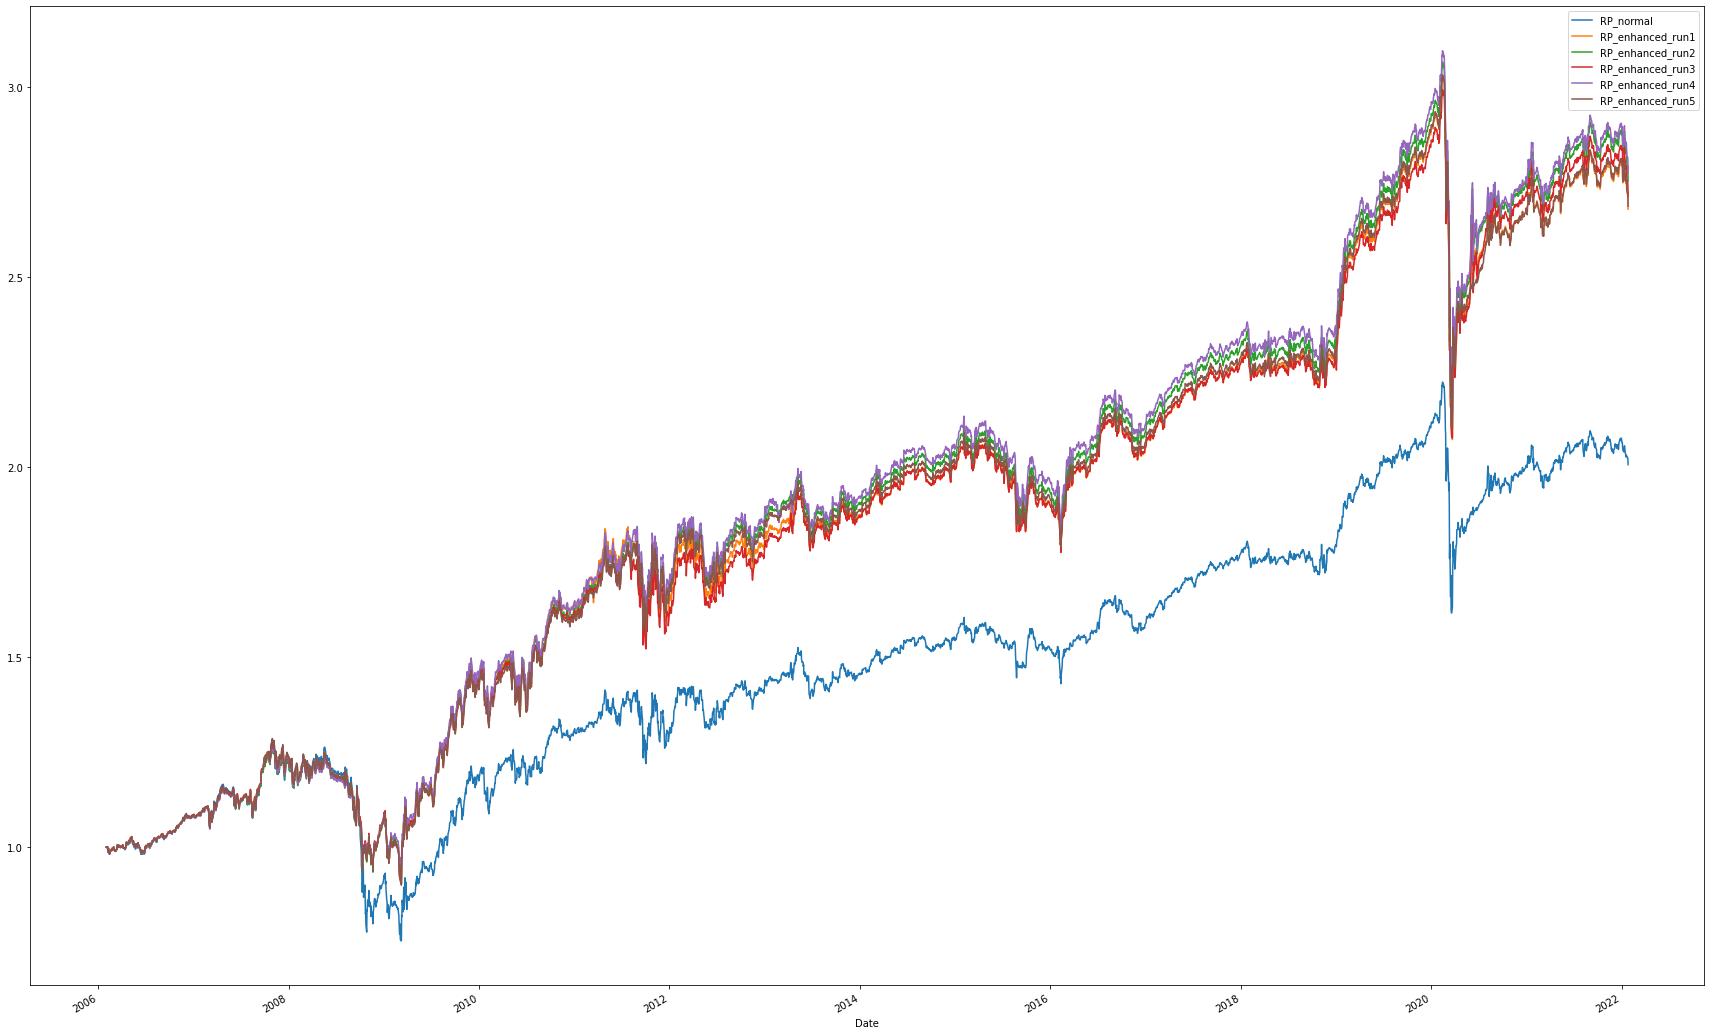

In [8]:
df.plot(figsize=(30,20))

In [5]:
def calc_rc(cov, w):
    rc = (cov @ w) * w
    var = w.T @ cov @ w
    return rc/var